<a href="https://colab.research.google.com/github/seeedata/Dacon/blob/main/%EC%98%A8%EB%9D%BC%EC%9D%B8%20%EC%B1%84%EB%84%90%20%EC%A0%9C%ED%92%88%20%ED%8C%90%EB%A7%A4%EB%9F%89%20%EC%98%88%EC%B8%A1%20AI%20%EC%98%A8%EB%9D%BC%EC%9D%B8%20%ED%95%B4%EC%BB%A4%ED%86%A4/0822%20xgboost%20%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LGaimers/data/train.csv', encoding='cp949'); train.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.shape

(15890, 465)

In [ ]:
len(train.columns)

465

#Preprocessing

1. ID별로 모델링하여 총 15890개의 모델을 만든다.

2. time series 데이터를 일반 회귀 문제로 변환한다.

#ID와 시간 변수만 있는 df1

In [ ]:
df1 = train.iloc[:, [0] + list(range(6, train.shape[1]))]; df1

,ID,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
df1 = df1.melt('ID'); df1

,ID,variable,value
0,0,2022-01-01,0
1,1,2022-01-01,0
2,2,2022-01-01,0
3,3,2022-01-01,0
4,4,2022-01-01,0
...,...,...,...
7293505,15885,2023-04-04,0
7293506,15886,2023-04-04,3
7293507,15887,2023-04-04,0
7293508,15888,2023-04-04,2


In [ ]:
df1.columns = ['ID', 'date', 'count']

In [ ]:
#ID별 정렬 -> 날짜별 정렬
df1 = df1.sort_values(['ID', 'date']); df1

,ID,date,count
0,0,2022-01-01,0
15890,0,2022-01-02,0
31780,0,2022-01-03,0
47670,0,2022-01-04,0
63560,0,2022-01-05,0
...,...,...,...
7229949,15889,2023-03-31,0
7245839,15889,2023-04-01,0
7261729,15889,2023-04-02,0
7277619,15889,2023-04-03,0


In [ ]:
df1.dtypes

ID        int64
date     object
count     int64
dtype: object

date 변수가 object이다. 이를 datetime으로 바꿔주자.

##date의 dtype을 datetime으로 변환

In [ ]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d'); df1.head()

,ID,date,count
0,0,2022-01-01,0
15890,0,2022-01-02,0
31780,0,2022-01-03,0
47670,0,2022-01-04,0
63560,0,2022-01-05,0


In [ ]:
df1.dtypes

ID                int64
date     datetime64[ns]
count             int64
dtype: object

##1. Date-Related Features

In [ ]:
df1['year'] = df1['date'].dt.year
df1['month'] = df1['date'].dt.month
df1['day'] = df1['date'].dt.day
df1['dayofweek_num'] = df1['date'].dt.dayofweek
df1['dayofweek_name'] = df1['date'].dt.day_name()
df1.head()

,ID,date,count,year,month,day,dayofweek_num,dayofweek_name
0,0,2022-01-01,0,2022,1,1,5,Saturday
15890,0,2022-01-02,0,2022,1,2,6,Sunday
31780,0,2022-01-03,0,2022,1,3,0,Monday
47670,0,2022-01-04,0,2022,1,4,1,Tuesday
63560,0,2022-01-05,0,2022,1,5,2,Wednesday


In [ ]:
df1.dtypes

ID                         int64
date              datetime64[ns]
count                      int64
year                       int64
month                      int64
day                        int64
dayofweek_num              int64
dayofweek_name            object
dtype: object

In [ ]:
#계절 변수 추가
df1.loc[df1['month'].isin([12, 1, 2]), 'season'] = 'winter'
df1.loc[df1['month'].isin([3, 4, 5]), 'season'] = 'spring'
df1.loc[df1['month'].isin([6, 7, 8]), 'season'] = 'summer'
df1.loc[df1['month'].isin([9, 10, 11]), 'season'] = 'fall'
df1

,ID,date,count,year,month,day,dayofweek_num,dayofweek_name,season
0,0,2022-01-01,0,2022,1,1,5,Saturday,winter
15890,0,2022-01-02,0,2022,1,2,6,Sunday,winter
31780,0,2022-01-03,0,2022,1,3,0,Monday,winter
47670,0,2022-01-04,0,2022,1,4,1,Tuesday,winter
63560,0,2022-01-05,0,2022,1,5,2,Wednesday,winter
...,...,...,...,...,...,...,...,...,...
7229949,15889,2023-03-31,0,2023,3,31,4,Friday,spring
7245839,15889,2023-04-01,0,2023,4,1,5,Saturday,spring
7261729,15889,2023-04-02,0,2023,4,2,6,Sunday,spring
7277619,15889,2023-04-03,0,2023,4,3,0,Monday,spring


##Lag Features

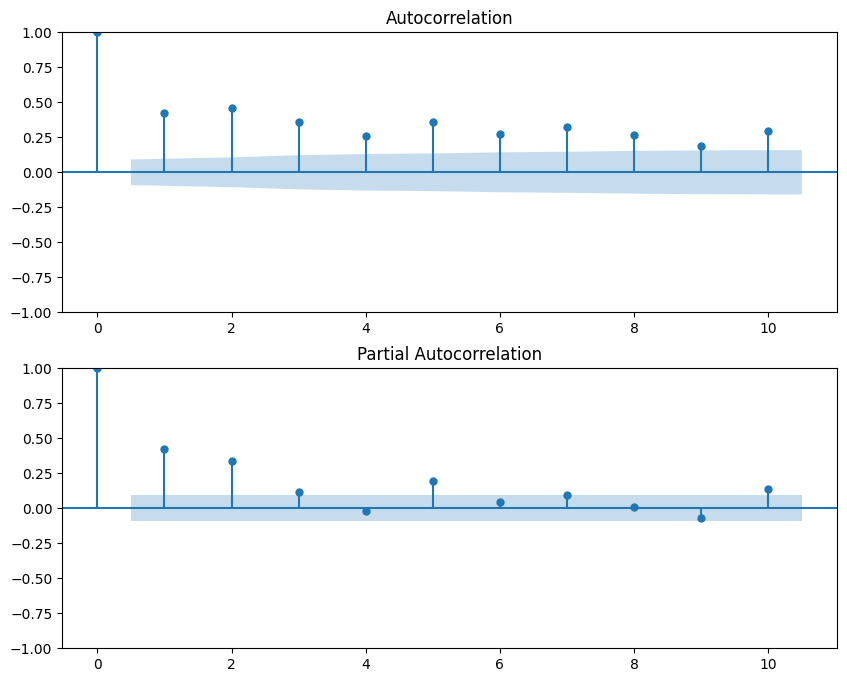

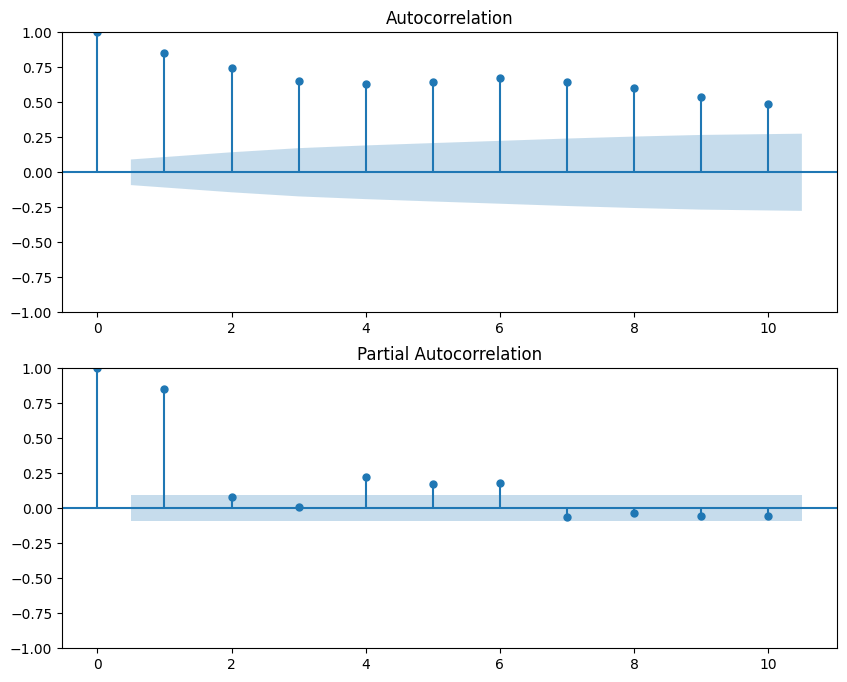

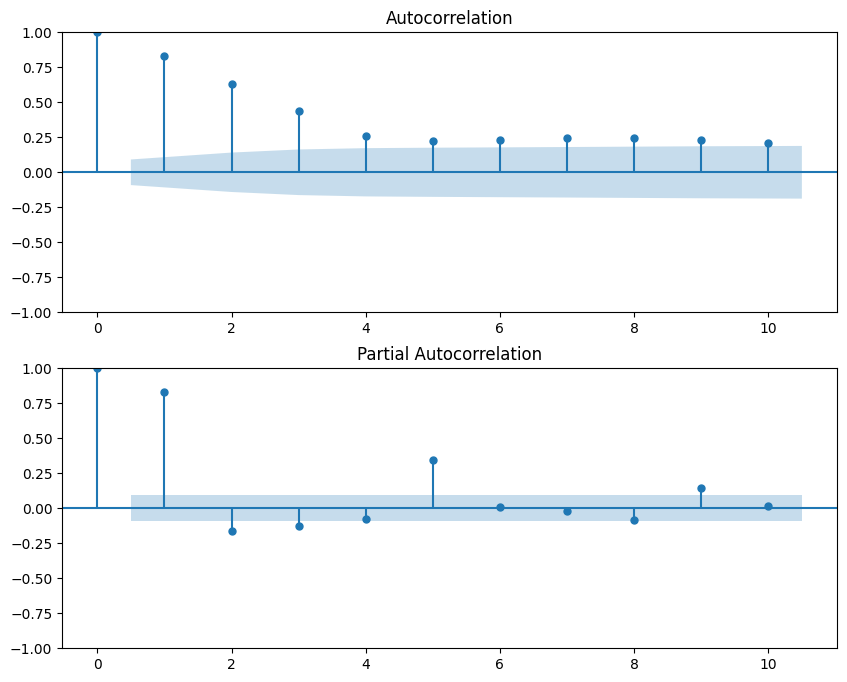

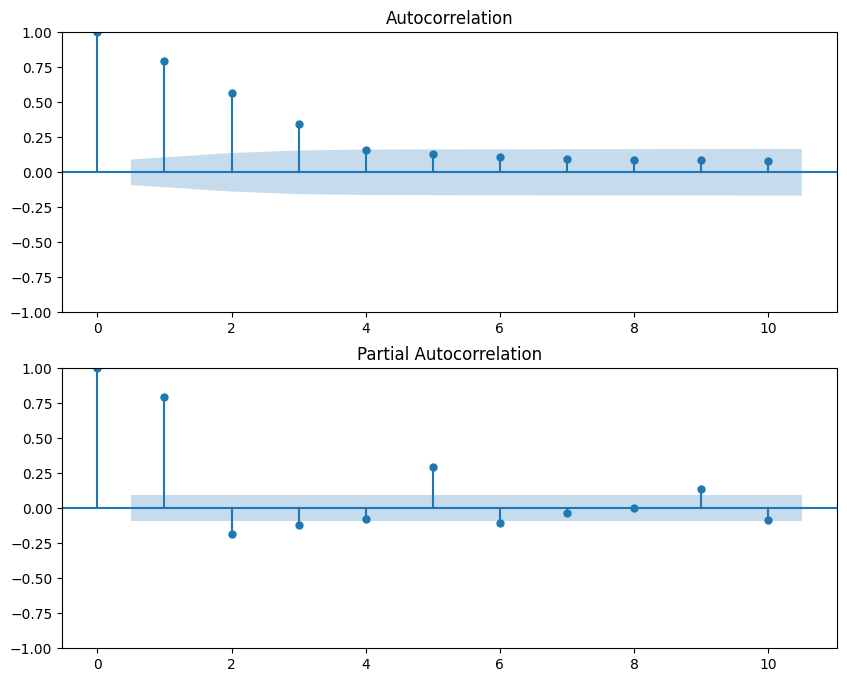

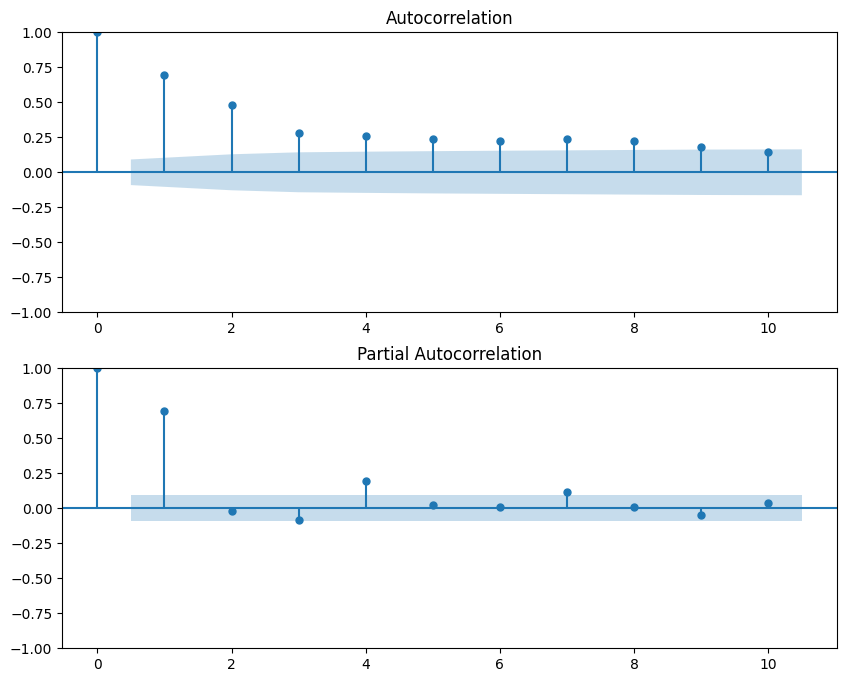

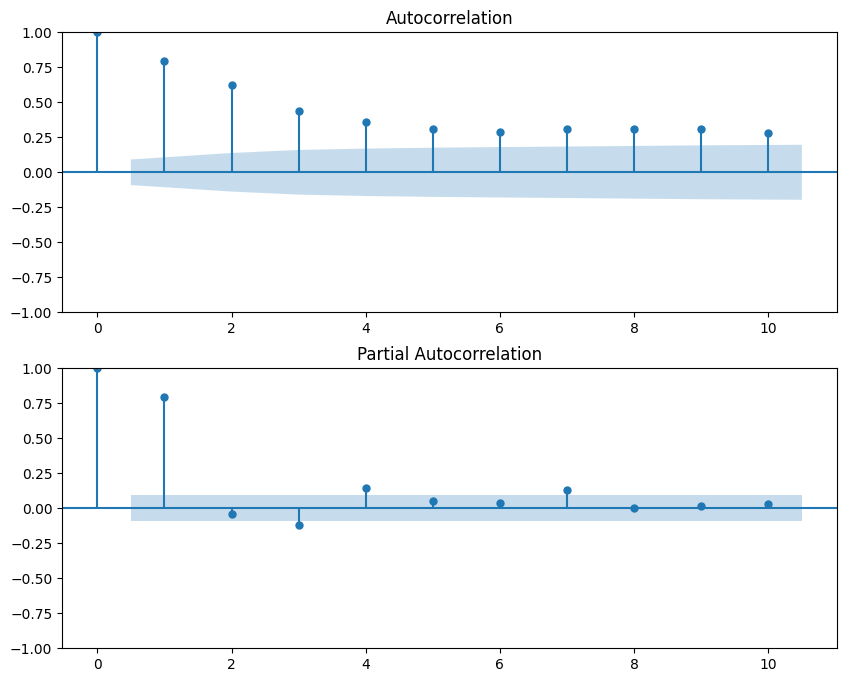

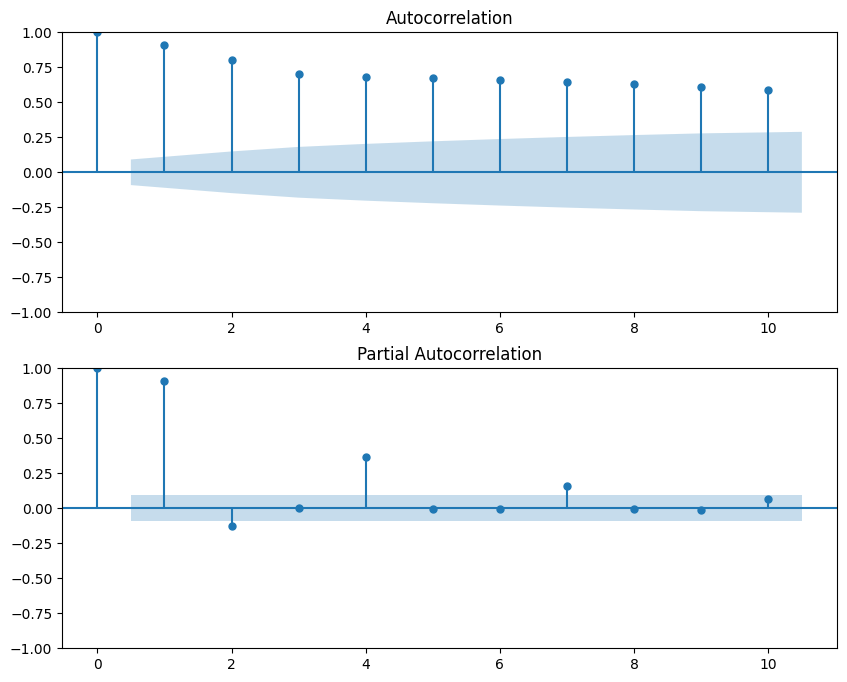

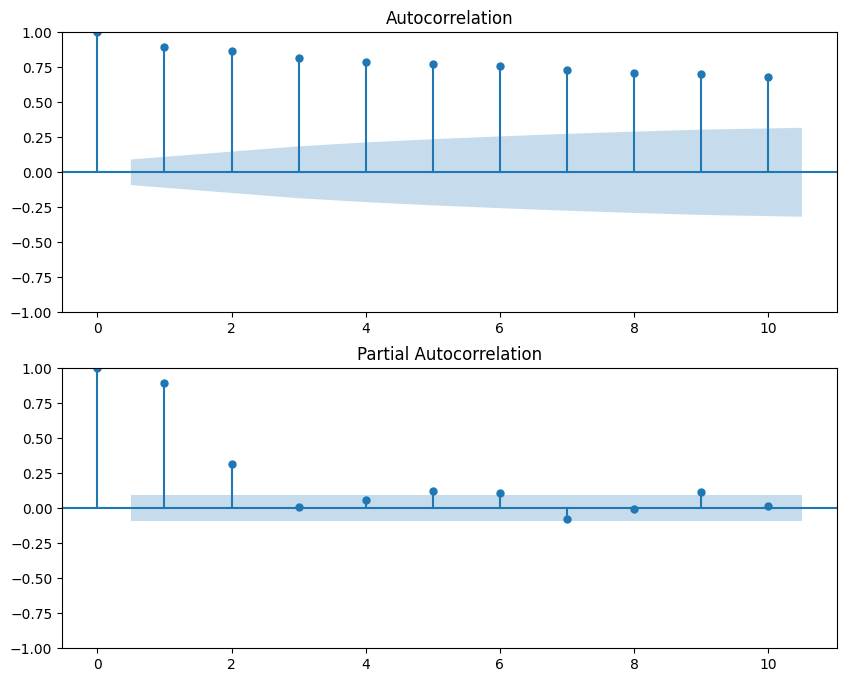

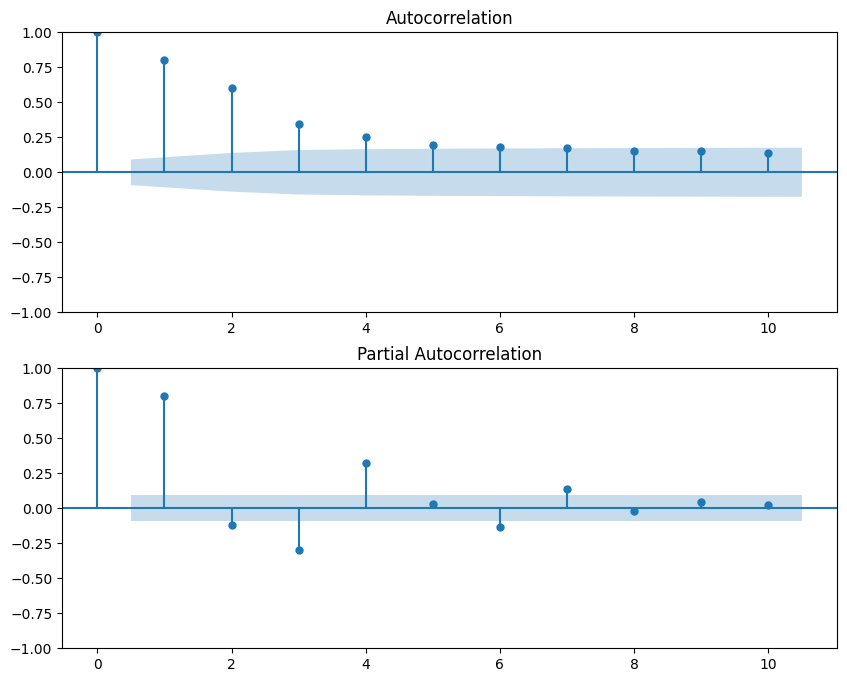

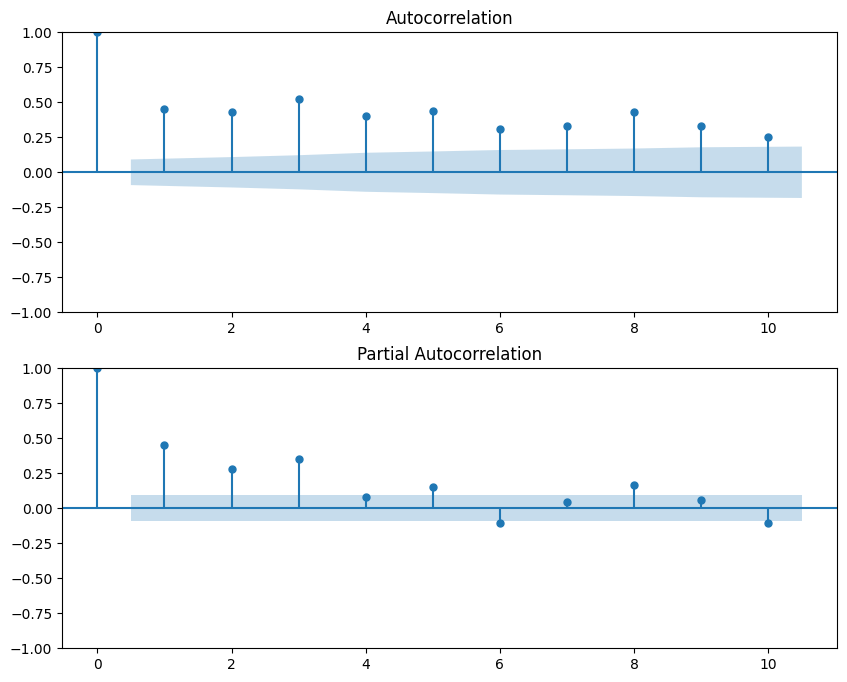

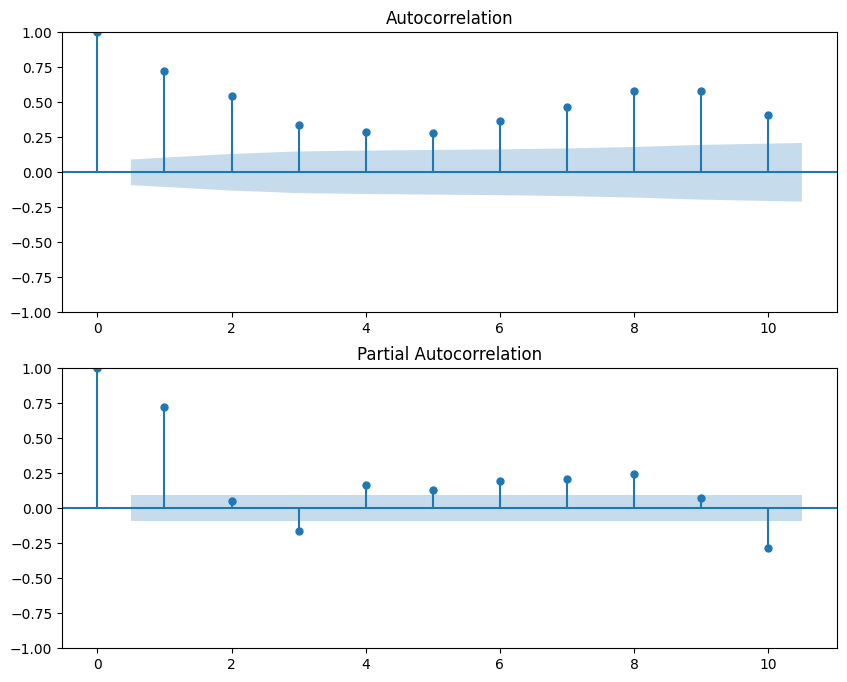

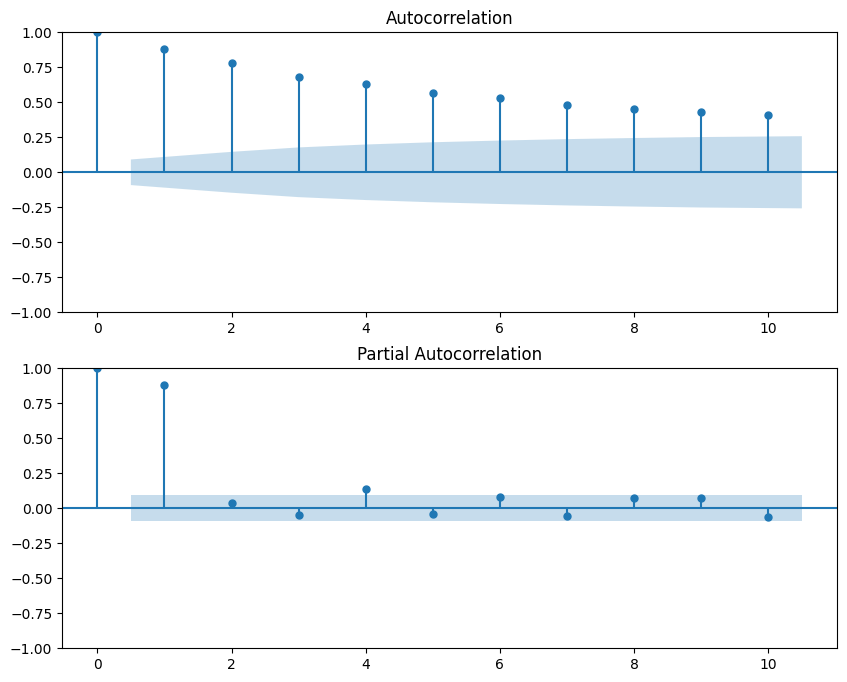

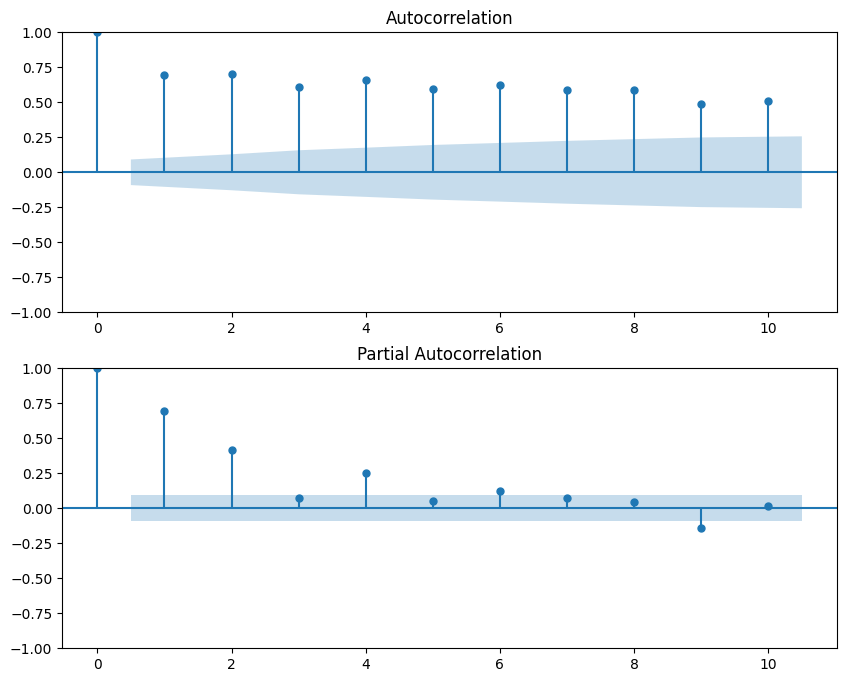

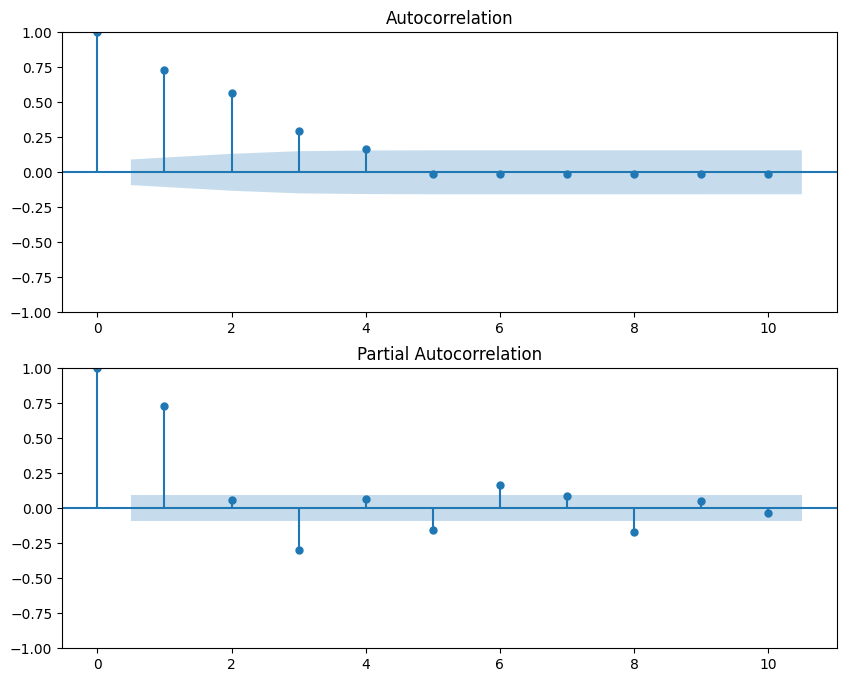

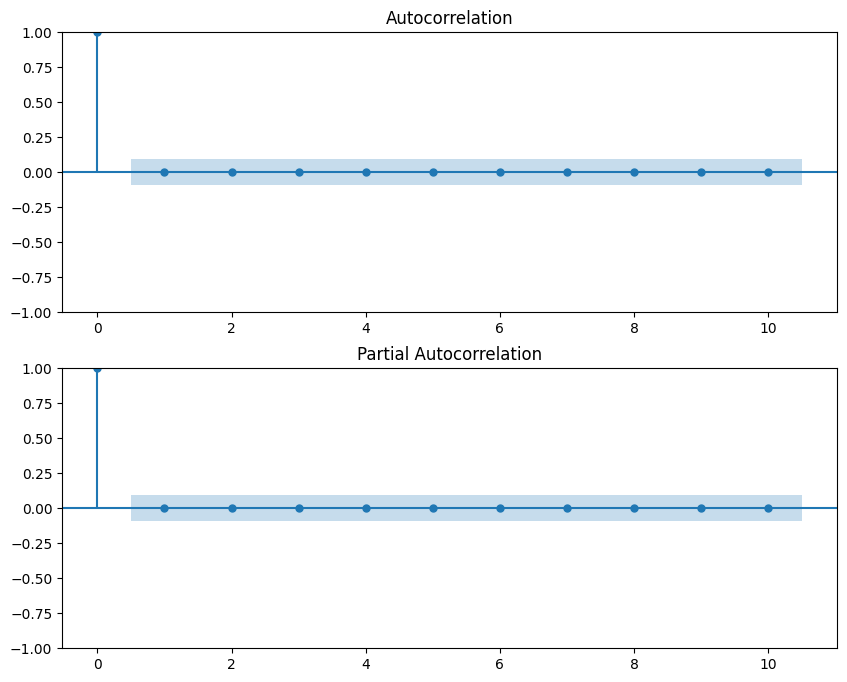

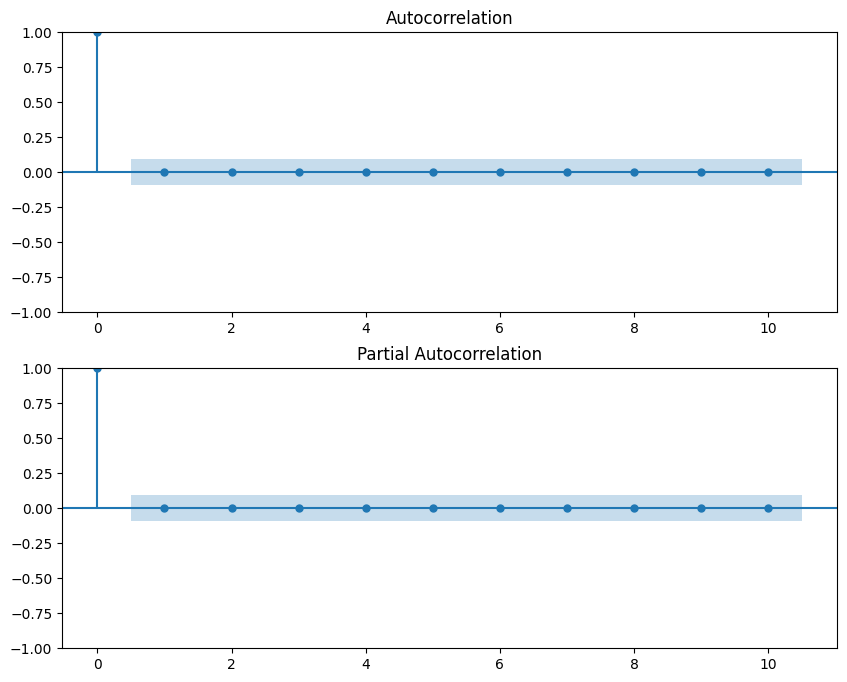

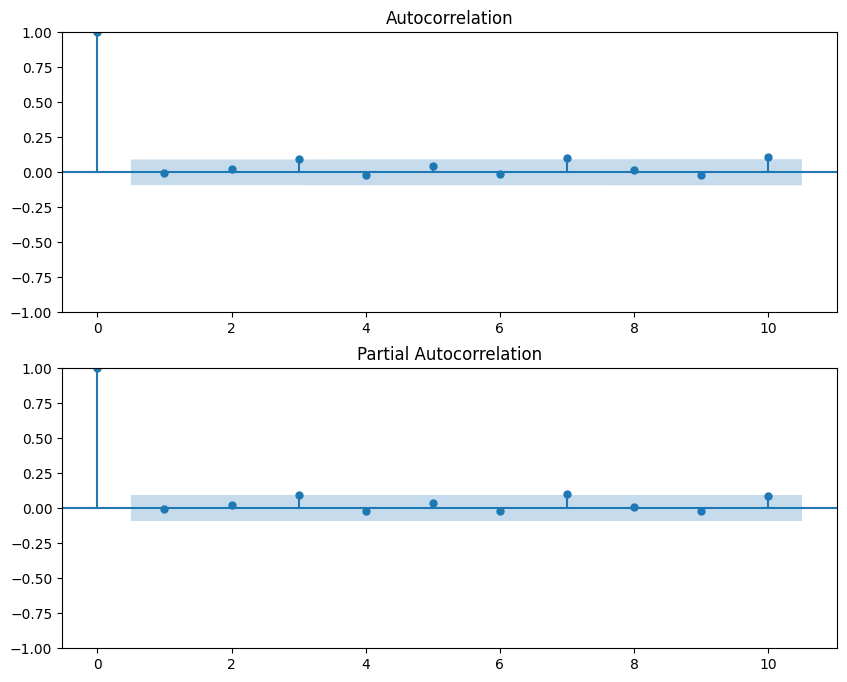

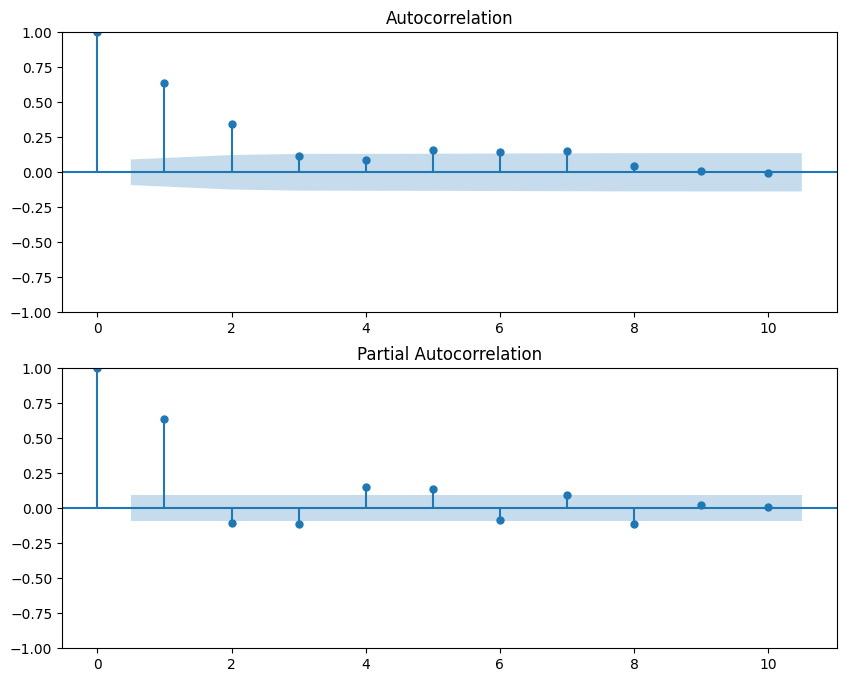

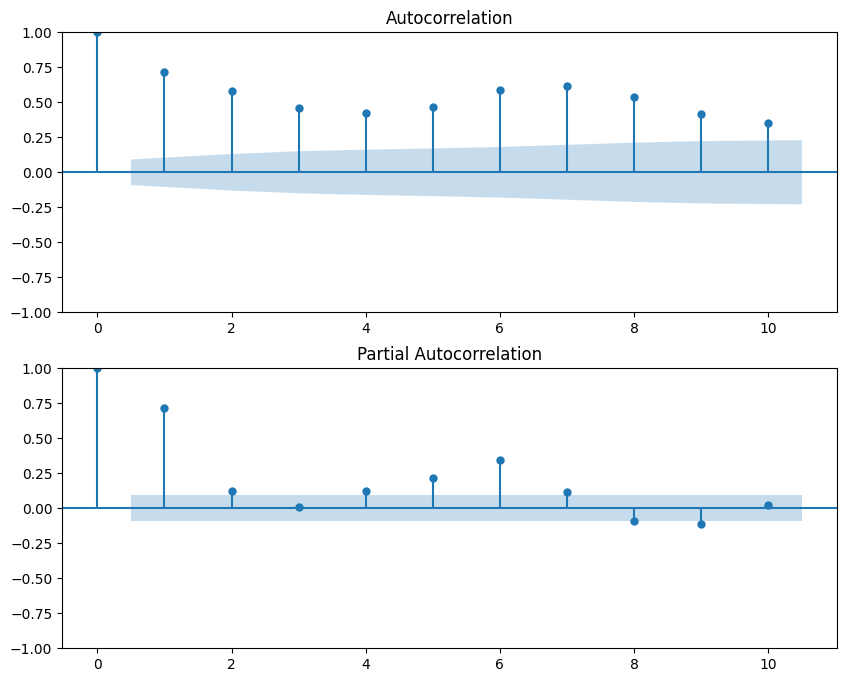

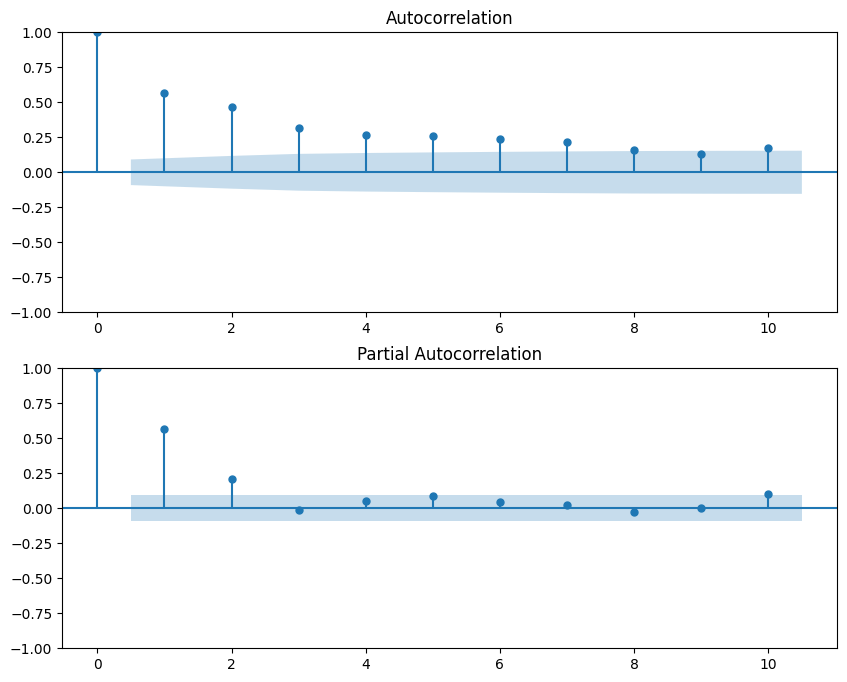

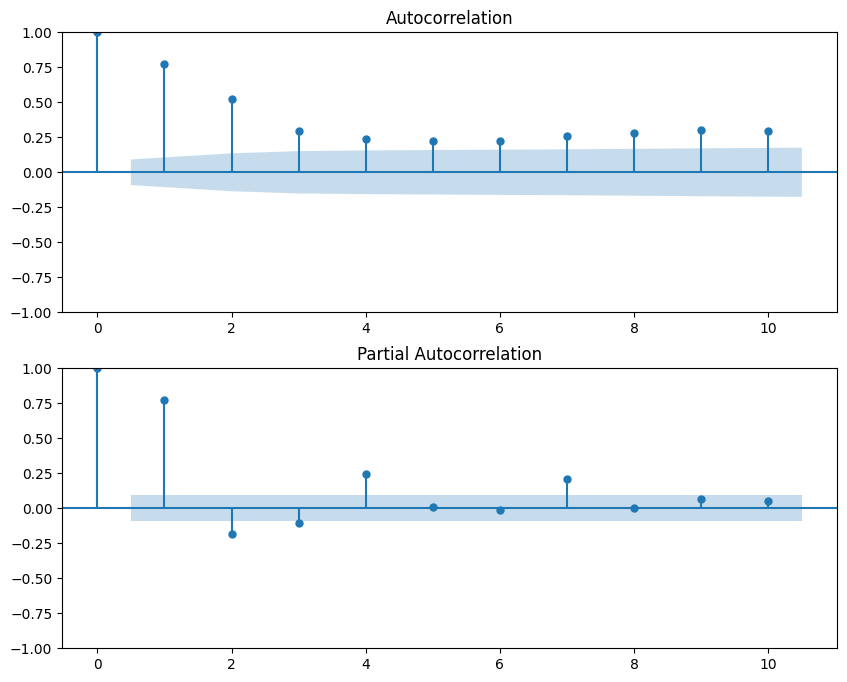

In [ ]:
for id in range(21):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
    plot_acf(df1[df1['ID']==id]['count'], lags=10, ax=ax1)
    plot_pacf(df1[df1['ID']==id]['count'], lags=10, ax=ax2)
    plt.show()

lag1부터 lag7까지 변수에 포함시켜서 model이 알아서 거르도록 하자.

In [ ]:
for id in tqdm(range(15890)):
    mask = df1['ID']==id
    df1.loc[mask,'lag_1'] = df1.loc[mask,'count'].shift(1)
    df1.loc[mask,'lag_2'] = df1.loc[mask,'count'].shift(2)
    df1.loc[mask,'lag_3'] = df1.loc[mask,'count'].shift(3)
    df1.loc[mask,'lag_4'] = df1.loc[mask,'count'].shift(4)
    df1.loc[mask,'lag_5'] = df1.loc[mask,'count'].shift(5)
    df1.loc[mask,'lag_6'] = df1.loc[mask,'count'].shift(6)
    df1.loc[mask,'lag_7'] = df1.loc[mask,'count'].shift(7)
df1

  2%|▏         | 392/15890 [00:25<16:35, 15.57it/s]


KeyboardInterrupt: ignored

In [ ]:
#이동평균 구하는 코드를 돌리다 말아서 추가함
df2 = df1.drop(['rolling_mean'], axis=1); df2.head()

,ID,date,count,year,month,day,dayofweek_num,dayofweek_name,season,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,0,2022-01-01,0,2022,1,1,5,Saturday,winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15890,0,2022-01-02,0,2022,1,2,6,Sunday,winter,0.0,NaN,NaN,NaN,NaN,NaN,NaN
31780,0,2022-01-03,0,2022,1,3,0,Monday,winter,0.0,0.0,NaN,NaN,NaN,NaN,NaN
47670,0,2022-01-04,0,2022,1,4,1,Tuesday,winter,0.0,0.0,0.0,NaN,NaN,NaN,NaN
63560,0,2022-01-05,0,2022,1,5,2,Wednesday,winter,0.0,0.0,0.0,0.0,NaN,NaN,NaN


##Rolling Window Feature

평균 계산에 최근 5일 데이터만 사용

In [ ]:
for id in tqdm(range(15890)):
    mask = df2['ID']==id
    df2.loc[mask,'rolling_mean'] = df2.loc[mask,'count'].rolling(window=5).mean()
df2

100%|██████████| 15890/15890 [03:08<00:00, 84.18it/s]


,ID,date,count,year,month,day,dayofweek_num,dayofweek_name,season,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
0,0,2022-01-01,0,2022,1,1,5,Saturday,winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15890,0,2022-01-02,0,2022,1,2,6,Sunday,winter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31780,0,2022-01-03,0,2022,1,3,0,Monday,winter,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
47670,0,2022-01-04,0,2022,1,4,1,Tuesday,winter,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
63560,0,2022-01-05,0,2022,1,5,2,Wednesday,winter,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7229949,15889,2023-03-31,0,2023,3,31,4,Friday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7245839,15889,2023-04-01,0,2023,4,1,5,Saturday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7261729,15889,2023-04-02,0,2023,4,2,6,Sunday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7277619,15889,2023-04-03,0,2023,4,3,0,Monday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Domain-Specific Features

###설날, 추석

In [ ]:
print(pd.Timestamp(2022,1,31).date())

2022-01-31


In [ ]:
#설날, 추석 연휴(전후에 주말 끼어 있으면 그때도 포함, 대체공휴일도 포함)
holiday_list = [(2022,1,29), (2022,1,30), (2022,1,31), (2022,2,1), (2022,2,2),  #22설날
                (2022,9,9), (2022,9,10), (2022,9,11), (2022,9,12),  #22추석
                (2023,1,21), (2023,1,22), (2023,1,23), (2023,1,24)  #23설날
                ]
holiday_list_format = [pd.Timestamp(*date).date() for date in holiday_list]
print(holiday_list_format)

[datetime.date(2022, 1, 29), datetime.date(2022, 1, 30), datetime.date(2022, 1, 31), datetime.date(2022, 2, 1), datetime.date(2022, 2, 2), datetime.date(2022, 9, 9), datetime.date(2022, 9, 10), datetime.date(2022, 9, 11), datetime.date(2022, 9, 12), datetime.date(2023, 1, 21), datetime.date(2023, 1, 22), datetime.date(2023, 1, 23), datetime.date(2023, 1, 24)]


In [ ]:
df3 = df2.copy()

In [ ]:
df3.loc[df3['date'].isin(holiday_list_format), 'holiday'] = 1; df3

,ID,date,count,year,month,day,dayofweek_num,dayofweek_name,season,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday
0,0,2022-01-01,0,2022,1,1,5,Saturday,winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15890,0,2022-01-02,0,2022,1,2,6,Sunday,winter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31780,0,2022-01-03,0,2022,1,3,0,Monday,winter,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47670,0,2022-01-04,0,2022,1,4,1,Tuesday,winter,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
63560,0,2022-01-05,0,2022,1,5,2,Wednesday,winter,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7229949,15889,2023-03-31,0,2023,3,31,4,Friday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7245839,15889,2023-04-01,0,2023,4,1,5,Saturday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7261729,15889,2023-04-02,0,2023,4,2,6,Sunday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7277619,15889,2023-04-03,0,2023,4,3,0,Monday,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
df3['holiday'].fillna(0, inplace=True); df3.head()

,ID,date,count,year,month,day,dayofweek_num,dayofweek_name,season,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday
0,0,2022-01-01,0,2022,1,1,5,Saturday,winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
15890,0,2022-01-02,0,2022,1,2,6,Sunday,winter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
31780,0,2022-01-03,0,2022,1,3,0,Monday,winter,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
47670,0,2022-01-04,0,2022,1,4,1,Tuesday,winter,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
63560,0,2022-01-05,0,2022,1,5,2,Wednesday,winter,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0


### 시간 관련 평균, 표준편차

1. id별 계절별 판매량 평균

2. id별 계절별 판매량 표준편차

평균 계산에 사용하는 달

봄:22년3,4,5월,23년3월 / 여름:22년6,7,8월 / 가을:22년9,10,11월 / 겨울1: 22년 1월,2월, 22년12월, 23년1,2월

-> 평균 계산에 사용안했어도 season 열에 따라서 추가

###id별 계절별 판매량 평균

In [ ]:
date_columns = train.columns[6:]  # 날짜 컬럼들 선택
seasonal_data = train.copy()

# 날짜 수만큼 반복
for col in date_columns:
    if col >= '2022-01-01' and col <= '2023-04-04':
        #2022-01까지만 추출
        year_month = col[:7]
        #선언 안되었으면 선언
        if year_month not in seasonal_data.columns:
            seasonal_data[year_month] = 0
        #2022-01에 1월달 값 다 넣기
        seasonal_data[year_month] += train[col]
        #이후 반복
seasonal_data.columns

Index(['ID', '제품', '대분류', '중분류', '소분류', '브랜드', '2022-01-01', '2022-01-02',
       '2022-01-03', '2022-01-04',
       ...
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04'],
      dtype='object', length=481)

In [ ]:
seasonal_data['spring_mean'] = seasonal_data[['2022-03', '2022-04', '2022-05', '2023-03']].mean(axis=1)
seasonal_data['summer_mean'] = seasonal_data[['2022-06', '2022-07', '2022-08']].mean(axis=1)
seasonal_data['fall_mean'] = seasonal_data[['2022-09', '2022-10', '2022-11']].mean(axis=1)
seasonal_data['winter_mean'] = seasonal_data[['2022-01', '2022-02', '2022-12', '2023-01', '2023-02']].mean(axis=1)

seasonal_data

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,spring_mean,summer_mean,fall_mean,winter_mean
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,32,61,93,50,0,0,14.50,0.000000,24.000000,42.6
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,1,0,38,20,6,2,71.75,67.333333,12.000000,12.2
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,29,37,19,0,0,0,106.75,143.000000,37.666667,13.6
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,32,3,0,0,0,0,177.50,161.666667,47.000000,50.4
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,382,202,70,73,0,0,96.25,0.000000,154.666667,75.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,...,928,680,572,501,0,0,379.50,117.666667,748.666667,350.6
15886,15886,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,96,195,282,650,5,9,1.25,204.000000,113.333333,225.4
15887,15887,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,30,14,2,3,0,0,265.25,175.000000,35.000000,18.4
15888,15888,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,51,31,38,17,0,2,28.25,194.000000,90.000000,18.0


In [ ]:
seasonal_data = seasonal_data[['ID', 'spring_mean', 'summer_mean', 'fall_mean', 'winter_mean']]; seasonal_data.head()

,ID,spring_mean,summer_mean,fall_mean,winter_mean
0,0,14.50,0.000000,24.000000,42.6
1,1,71.75,67.333333,12.000000,12.2
2,2,106.75,143.000000,37.666667,13.6
3,3,177.50,161.666667,47.000000,50.4
4,4,96.25,0.000000,154.666667,75.2


In [ ]:
dfnew = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LGaimers/id별계절별평균없는전처리데이터.csv')
dfnew.drop(['Unnamed: 0'], axis=1, inplace=True); dfnew

,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,season,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,...,winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-02,0,2022,1,...,winter,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-03,0,2022,1,...,winter,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-04,0,2022,1,...,winter,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-05,0,2022,1,...,winter,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-03-31,0,2023,3,...,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293506,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-01,0,2023,4,...,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293507,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-02,0,2023,4,...,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293508,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-03,0,2023,4,...,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_spring = dfnew.loc[dfnew['season']=='spring', :]
df_summer = dfnew.loc[dfnew['season']=='summer', :]
df_fall = dfnew.loc[dfnew['season']=='fall', :]
df_winter = dfnew.loc[dfnew['season']=='winter', :]

In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_spring['ID']==id
    mask2 = seasonal_data['ID']=id
    df_spring.loc[mask1, 'id_season_mean'] = seasonal_data.loc[mask2, 'spring_mean']
df_spring

100%|██████████| 15890/15890 [00:48<00:00, 328.18it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean
59,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-01,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5
60,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-02,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5
61,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-03,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5
62,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-04,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5
63,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-05,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-03-31,0,2023,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293506,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-01,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293507,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-02,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293508,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-03,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_summer['ID']==id
    mask2 = seasonal_data['ID']=id
    df_summer.loc[mask1, 'id_season_mean'] = seasonal_data.loc[mask2, 'summer_mean']
df_summer

100%|██████████| 15890/15890 [00:38<00:00, 414.03it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean
151,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-01,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-02,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-03,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-04,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-05,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293289,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-27,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293290,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-28,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293291,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-29,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293292,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-30,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_fall['ID']==id
    mask2 = seasonal_data['ID']=id
    df_fall.loc[mask1, 'id_season_mean'] = seasonal_data.loc[mask2, 'fall_mean']
df_fall

100%|██████████| 15890/15890 [00:37<00:00, 419.88it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean
243,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-01,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
244,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-02,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
245,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-03,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
246,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-04,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
247,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-05,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293380,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-26,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293381,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-27,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293382,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-28,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293383,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-29,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_winter['ID']==id
    mask2 = seasonal_data['ID']=id
    df_winter.loc[mask1, 'id_season_mean'] = seasonal_data.loc[mask2, 'winter_mean']
df_winter

100%|██████████| 15890/15890 [00:54<00:00, 293.04it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6
1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-02,0,2022,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6
2,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-03,0,2022,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6
3,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-04,0,2022,1,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,42.6
4,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-05,0,2022,1,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,42.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293470,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-24,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
7293471,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-25,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
7293472,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-26,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2
7293473,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-27,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


###id별 계절별 판매량 표준편차

In [ ]:
date_columns = train.columns[6:]  # 날짜 컬럼들 선택
seasonal_data = train.copy()

# 날짜 수만큼 반복
for col in date_columns:
    if col >= '2022-01-01' and col <= '2023-04-04':
        #2022-01까지만 추출
        year_month = col[:7]
        #선언 안되었으면 선언
        if year_month not in seasonal_data.columns:
            seasonal_data[year_month] = 0
        #2022-01에 1월달 값 다 넣기
        seasonal_data[year_month] += train[col]
        #이후 반복
seasonal_data.columns

Index(['ID', '제품', '대분류', '중분류', '소분류', '브랜드', '2022-01-01', '2022-01-02',
       '2022-01-03', '2022-01-04',
       ...
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04'],
      dtype='object', length=481)

In [ ]:
seasonal_data['spring_std'] = seasonal_data[['2022-03', '2022-04', '2022-05', '2023-03']].std(axis=1)
seasonal_data['summer_std'] = seasonal_data[['2022-06', '2022-07', '2022-08']].std(axis=1)
seasonal_data['fall_std'] = seasonal_data[['2022-09', '2022-10', '2022-11']].std(axis=1)
seasonal_data['winter_std'] = seasonal_data[['2022-01', '2022-02', '2022-12', '2023-01', '2023-02']].std(axis=1)

seasonal_data

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,spring_std,summer_std,fall_std,winter_std
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,32,61,93,50,0,0,15.502688,0.000000,20.223748,38.331449
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,1,0,38,20,6,2,54.328476,28.536526,9.539392,16.649324
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,29,37,19,0,0,0,86.707843,26.057628,11.718931,15.404545
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,32,3,0,0,0,0,172.536953,58.157831,20.223748,108.799357
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,382,202,70,73,0,0,111.511958,0.000000,201.100307,76.516011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,...,928,680,572,501,0,0,329.741818,42.253205,157.306495,326.336942
15886,15886,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,96,195,282,650,5,9,2.500000,125.191853,15.011107,267.405684
15887,15887,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,30,14,2,3,0,0,189.696907,119.616052,16.093477,20.007499
15888,15888,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,...,51,31,38,17,0,2,53.218888,31.480152,39.000000,16.507574


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_spring['ID']==id
    mask2 = seasonal_data['ID']=id
    df_spring.loc[mask1, 'id_season_std'] = seasonal_data.loc[mask2, 'spring_std']
df_spring

100%|██████████| 15890/15890 [00:47<00:00, 333.87it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean,id_season_std
59,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-01,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
60,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-02,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
61,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-03,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
62,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-04,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
63,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-05,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-03-31,0,2023,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7293506,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-01,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7293507,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-02,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7293508,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-03,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_summer['ID']==id
    mask2 = seasonal_data['ID']=id
    df_summer.loc[mask1, 'id_season_std'] = seasonal_data.loc[mask2, 'summer_std']
df_summer

100%|██████████| 15890/15890 [00:36<00:00, 431.86it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean,id_season_std
151,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-01,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-02,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-03,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-04,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-06-05,0,2022,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293289,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-27,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293290,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-28,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293291,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-29,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7293292,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-08-30,0,2022,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_fall['ID']==id
    mask2 = seasonal_data['ID']=id
    df_fall.loc[mask1, 'id_season_std'] = seasonal_data.loc[mask2, 'fall_std']
df_fall

100%|██████████| 15890/15890 [00:36<00:00, 432.28it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean,id_season_std
243,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-01,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.223748
244,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-02,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.223748
245,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-03,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.223748
246,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-04,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.223748
247,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-09-05,0,2022,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,20.223748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293380,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-26,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7293381,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-27,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7293382,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-28,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7293383,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2022-11-29,0,2022,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
for id in tqdm(range(15890)):
    mask1 = df_winter['ID']==id
    mask2 = seasonal_data['ID']=id
    df_winter.loc[mask1, 'id_season_std'] = seasonal_data.loc[mask2, 'winter_std']
df_winter

100%|██████████| 15890/15890 [00:53<00:00, 297.97it/s]


,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean,id_season_std
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-02,0,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
2,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-03,0,2022,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
3,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-04,0,2022,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
4,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-05,0,2022,1,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,42.6,38.331449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293470,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-24,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214
7293471,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-25,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214
7293472,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-26,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214
7293473,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-27,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214


In [ ]:
dftotal = pd.concat([df_spring, df_summer, df_fall, df_winter], ignore_index = True); dftotal

,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean,id_season_std
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-01,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
1,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-02,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
2,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-03,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
3,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-04,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
4,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-03-05,0,2022,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,15.502688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293505,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-24,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214
7293506,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-25,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214
7293507,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-26,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214
7293508,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-02-27,0,2023,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.447214


In [ ]:
dftotal = dftotal.sort_values(['ID', 'date']); dftotal

,ID,제품,대분류,중분류,소분류,브랜드,date,count,year,month,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,holiday,id_season_mean,id_season_std
4925900,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-01,0,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
4925901,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-02,0,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
4925902,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-03,0,2022,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
4925903,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-04,0,2022,1,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,42.6,38.331449
4925904,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,2022-01-05,0,2022,1,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,42.6,38.331449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018025,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-03-31,0,2023,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018026,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-01,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018027,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-02,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018028,15889,B002-03799-00010,B002-C001-0002,B002-C002-0004,B002-C003-0020,B002-03799,2023-04-03,0,2023,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [ ]:
dftotal.to_csv('/content/drive/MyDrive/Colab Notebooks/LGaimers/xgboost전처리최종.csv', index=False)